In [2]:
import os 
import json
import numpy as np
import pandas as pd
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.metrics import roc_auc_score, mean_squared_error

In [3]:
import os
# Office
os.chdir('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction')
data = pd.read_csv('LoanTrain.csv')

# Personal
#os.chdir('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction')
#data = pd.read_csv('Loan Prediction Train.csv')

#### Listing the columns persent in the dataset

In [6]:
a=data.reset_index(drop=True)

In [9]:
## Verifying the Constant Fields

#### Handling the Missing Values

In [4]:
data.loc[data['Gender'].isnull(),'Gender']='Trasgender'
data.loc[data['Dependents'].isnull(),'Dependents']='0'
data.loc[data['Married'].isnull(),'Married']='No'
data.loc[data['Self_Employed'].isnull(),'Self_Employed']='No'
data=data.drop(index=data.loc[data['LoanAmount'].isnull(),:].index)
data.loc[data['Loan_Amount_Term'].isnull(),'Loan_Amount_Term']=0
data.loc[data['Credit_History'].isnull(),'Credit_History']=0

In [5]:
Numeric_columns=data.select_dtypes(include=['int64','float64'])
categorical_columns=data.select_dtypes(include=['object'])
print(Numeric_columns.columns)
print(categorical_columns.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


#### Constant Values in Numeric Columns

In [7]:
from sklearn.feature_selection import VarianceThreshold

#Using a Built In Function
sel = VarianceThreshold(threshold=0)
sel.fit(Numeric_columns)  # fit finds the features with zero variance
print('Total # of non constant features',sum(sel.get_support()))
sel.transform(Numeric_columns)
Nonconstant_Numeric=Numeric_columns.loc[:,list(sel.get_support())]
#Nonconstant_Numeric

##Generic Way
#constant_numeric_features=[i for i in Numeric_columns.columns if Numeric_columns[i].std()==0]
#constant_numeric_features

Total # of non constant features 5


#### Constant Values in Categorical Columns

In [8]:
unique_columns=[]
for i in categorical_columns.columns:
    if len(categorical_columns[i].unique())==1:
        unique_columns.append(i)
print(unique_columns)

[]


#### Merging the two dataframes

In [9]:
new_df=pd.concat([categorical_columns,Nonconstant_Numeric],axis=1)
new_df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
Property_Area        0
Loan_Status          0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64

#### Removing the unique key columns

In [10]:
unique_columns=[i for i in new_df.columns if len(new_df[i].unique())==new_df.shape[0]]
print(unique_columns)

['Loan_ID']


#### Dropping the unique key columns

In [11]:
new_df=new_df.drop(unique_columns,axis=1)

#### Type conversion

In [12]:
new_df['Credit_History']=new_df['Credit_History'].astype(str)

#### Univariate Analysis

Plot for:  Gender


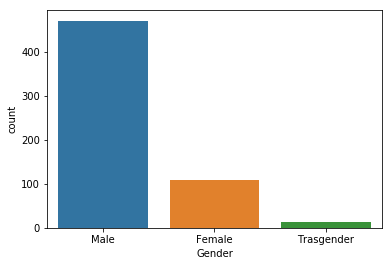

Plot for:  Married


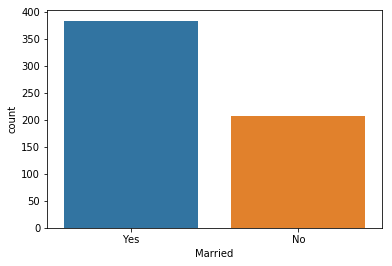

Plot for:  Dependents


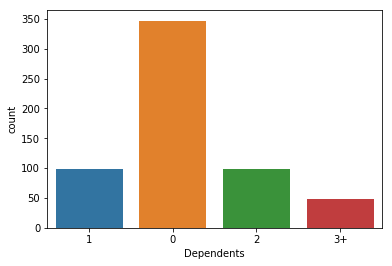

Plot for:  Education


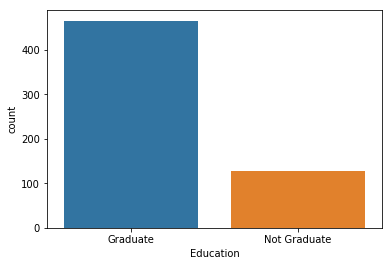

Plot for:  Self_Employed


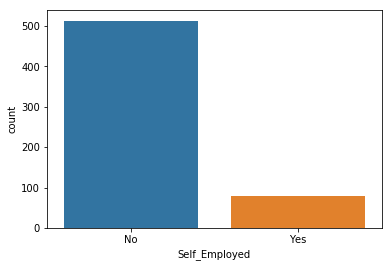

Plot for:  Property_Area


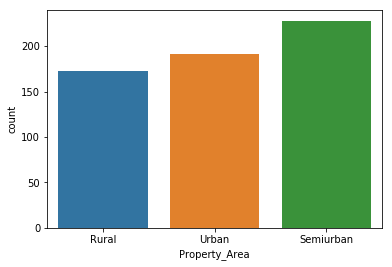

Plot for:  Loan_Status


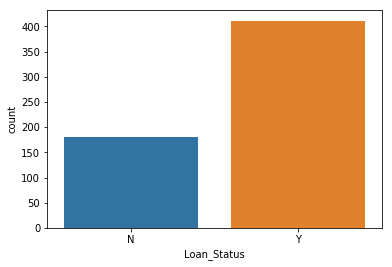

Plot for:  Credit_History


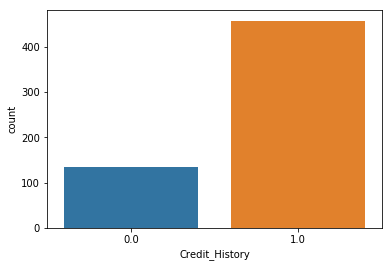

In [13]:
for feat in new_df.select_dtypes(include=['object']).columns:
    print('Plot for: ',feat)
    sns.countplot(new_df[feat])
    plt.show()

Plot for:  Gender  vs Loan Status


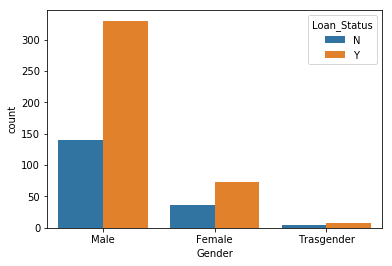

Plot for:  Married  vs Loan Status


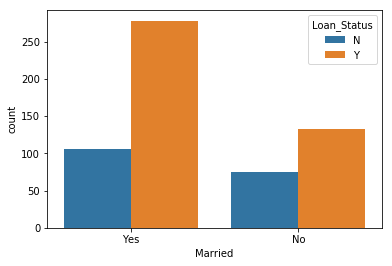

Plot for:  Dependents  vs Loan Status


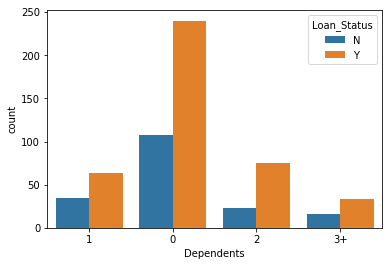

Plot for:  Education  vs Loan Status


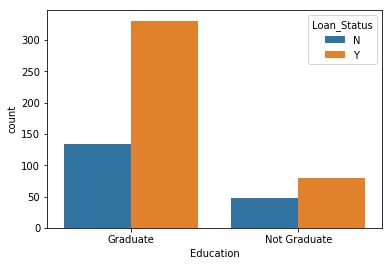

Plot for:  Self_Employed  vs Loan Status


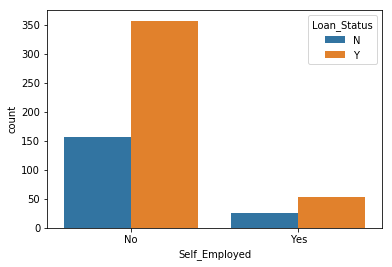

Plot for:  Property_Area  vs Loan Status


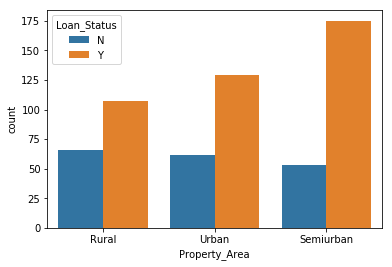

Plot for:  Credit_History  vs Loan Status


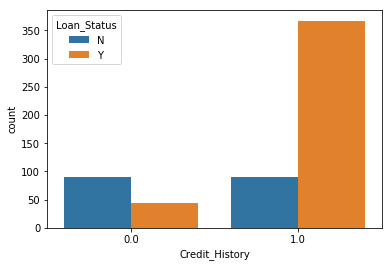

In [22]:
for feat in new_df.select_dtypes(include=['object']).columns:
    if feat !='Loan_Status':
        print('Plot for: ',feat,' vs Loan Status')
        sns.countplot(new_df[feat],hue=new_df['Loan_Status'])
        plt.show()

In [14]:
## Unmarried ppl are more likely to get a loan, hence considering the "Married column" for future analysis
## Persons with zero or 1 dependents are more likely to get a loan, hence considering "Dependents column" for future analysis
## Graduates are more likely to get a loan when compared to "Not Graduate"
## Non Self employees are more likely to get a loan when compared to self employeed 

#### Removing the gender column as this is not explaining the output variable
#new_df=new_df.drop(['Gender'],axis=1)

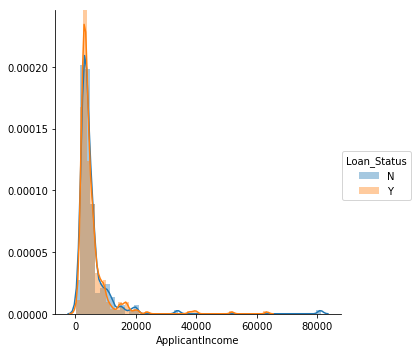

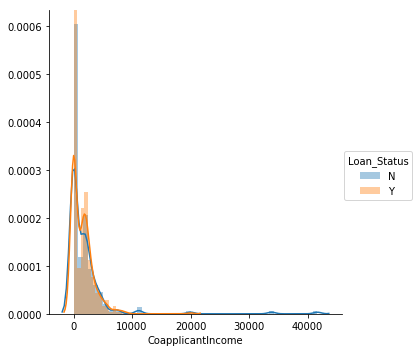

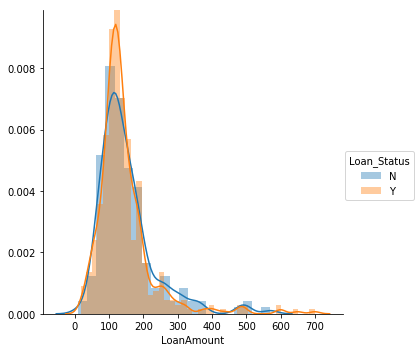

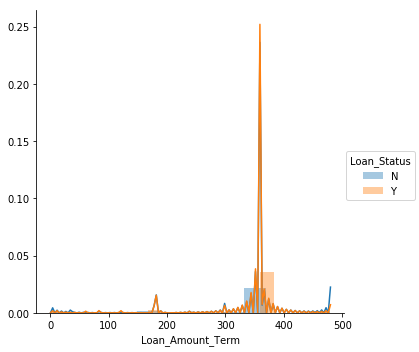

In [15]:
for feat in new_df.select_dtypes(include=['int64','float64']).columns:
    sns.FacetGrid(new_df,hue='Loan_Status',aspect=1,size=5)\
        .map(sns.distplot,feat)\
        .add_legend()
plt.show()

In [16]:
corr=pd.DataFrame(new_df.select_dtypes(include=['int64','float64']).corr())
print(corr)

                   ApplicantIncome  CoapplicantIncome  LoanAmount  \
ApplicantIncome           1.000000          -0.113695    0.570909   
CoapplicantIncome        -0.113695           1.000000    0.188619   
LoanAmount                0.570909           0.188619    1.000000   
Loan_Amount_Term         -0.016667          -0.049350    0.065089   

                   Loan_Amount_Term  
ApplicantIncome           -0.016667  
CoapplicantIncome         -0.049350  
LoanAmount                 0.065089  
Loan_Amount_Term           1.000000  


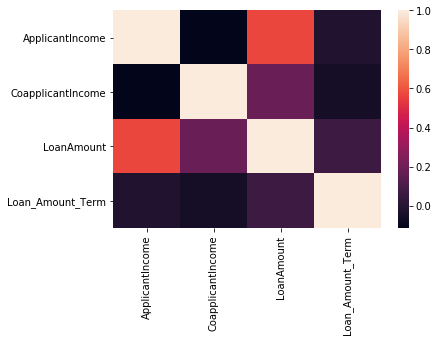

In [17]:
sns.heatmap(corr)

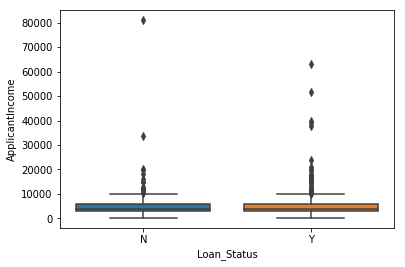

In [18]:
sns.boxplot('Loan_Status','ApplicantIncome',data=new_df)

Feature:  ApplicantIncome


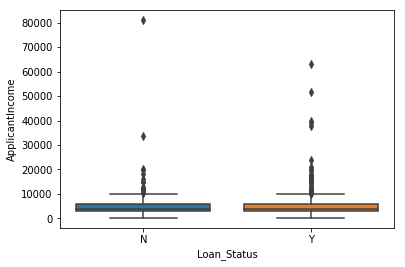

Feature:  CoapplicantIncome


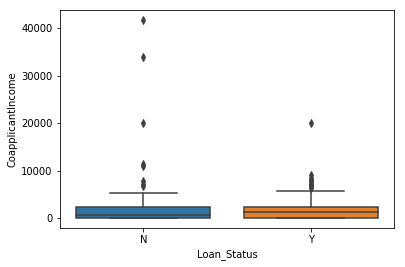

Feature:  LoanAmount


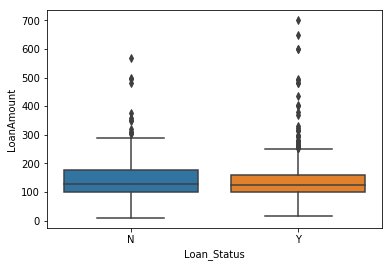

Feature:  Loan_Amount_Term


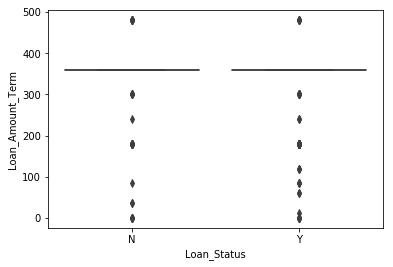

In [19]:
for feat in new_df.select_dtypes(include=['int64','float64']).columns:
    print("Feature: ", feat)
    sns.boxplot('Loan_Status',feat,data=new_df)
    plt.show()

In [20]:
IQR=new_df['ApplicantIncome'].quantile(0.75)-new_df['ApplicantIncome'].quantile(0.25)
upper_fence=new_df['ApplicantIncome'].quantile(0.75)+(IQR*3)
lower_fence=new_df['ApplicantIncome'].quantile(0.75)-(IQR*3)
print(IQR,'  ', upper_fence,'  ',lower_fence)
new_df=new_df.loc[(new_df['ApplicantIncome']<=upper_fence) & (new_df['ApplicantIncome']>=lower_fence), :]

2867.25    14356.25    -2847.25


(array([ 17.,   6.,   3.,  39.,   0.,   3.,  12., 467.,   0.,  14.]),
 array([  0.,  48.,  96., 144., 192., 240., 288., 336., 384., 432., 480.]),
 <a list of 10 Patch objects>)

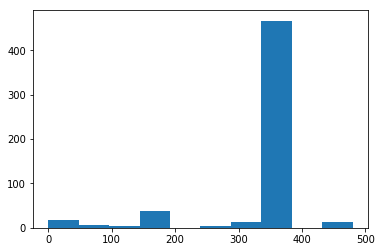

In [21]:
plt.hist(new_df['Loan_Amount_Term'])

In [22]:
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
encoding_minmax=defaultdict(MinMaxScaler)
features_num=['ApplicantIncome']
for feat in features_num:
    encoded_df=pd.DataFrame()
    #d=pd.DataFrame(encoding_minmax(feat).fit_transform(new_df[feat]))
    d=pd.DataFrame(encoding_minmax[feat].fit_transform(new_df[[feat]]))
    test_column=d.columns.values
    list_column=[feat+'_'+'minmax' for j in test_column]
    d.columns=list_column
    encoded_df=pd.concat([encoded_df,d],axis=1).reset_index(drop=True)
    new_df.drop(feat,axis=1,inplace=True)
    new_df=new_df.reset_index(drop=True)
    new_df=pd.concat([new_df,encoded_df],axis=1)
import pickle
#with open('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\minmax_pickle.pkl','wb') as f:
#    pickle.dump(encoding_minmax,f)
#office
with open('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\minmax_pickle.pkl','wb') as f:
    pickle.dump(encoding_minmax,f)

In [23]:
from sklearn.preprocessing import StandardScaler
from collections import defaultdict
encoding_standardscaler=defaultdict(StandardScaler)
features_num=['LoanAmount']
for feat in features_num:
    encoded_df=pd.DataFrame()
    #d=pd.DataFrame(encoding_minmax(feat).fit_transform(new_df[feat]))
    d=pd.DataFrame(encoding_standardscaler[feat].fit_transform(new_df[[feat]]))
    test_column=d.columns.values
    list_column=[feat+'_'+'minmax' for j in test_column]
    d.columns=list_column
    encoded_df=pd.concat([encoded_df,d],axis=1).reset_index(drop=True)
    new_df.drop(feat,axis=1,inplace=True)
    new_df=new_df.reset_index(drop=True)
    new_df=pd.concat([new_df,encoded_df],axis=1)
#with open('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\standardscaler_pickle.pkl','wb') as f:
#    pickle.dump(encoding_standardscaler,f)
with open('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\standardscaler_pickle.pkl','wb') as f:
    pickle.dump(encoding_standardscaler,f)

#### Engineering the Rare Variables

In [24]:
for feat in new_df.select_dtypes(include='object'):
    print('Feature counts of variable: ',feat)
    print(new_df[feat].value_counts())
    print('----------------------------------')

Feature counts of variable:  Gender
Male          447
Female        104
Trasgender     10
Name: Gender, dtype: int64
----------------------------------
Feature counts of variable:  Married
Yes    361
No     200
Name: Married, dtype: int64
----------------------------------
Feature counts of variable:  Dependents
0     331
2      94
1      92
3+     44
Name: Dependents, dtype: int64
----------------------------------
Feature counts of variable:  Education
Graduate        436
Not Graduate    125
Name: Education, dtype: int64
----------------------------------
Feature counts of variable:  Self_Employed
No     493
Yes     68
Name: Self_Employed, dtype: int64
----------------------------------
Feature counts of variable:  Property_Area
Semiurban    216
Urban        181
Rural        164
Name: Property_Area, dtype: int64
----------------------------------
Feature counts of variable:  Loan_Status
Y    388
N    173
Name: Loan_Status, dtype: int64
----------------------------------
Feature count

#### One Hot Encoding

In [25]:
from sklearn.preprocessing import LabelBinarizer
from collections import defaultdict
import pandas as pd
encoding_binarizer=defaultdict(LabelBinarizer)
col_nominal=['Self_Employed','Married','Gender']
for feat in col_nominal:
    encoded_df=pd.DataFrame()
    d=pd.DataFrame(encoding_binarizer[feat].fit_transform(new_df[feat]))
    test_column=d.columns.values
    list_columns=[feat+'_'+str(j) for j in test_column]
    #print(list_columns)
    d.columns=list_columns
    #print(d.head())
    encoded_df=pd.concat([encoded_df,d],axis=1).reset_index(drop=True)
    new_df.drop(feat,axis=1,inplace=True)
    new_df=new_df.reset_index(drop=True)
    new_df=pd.concat([new_df,encoded_df],axis=1)
#with open('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\binarizer_pickle.pkl','wb') as f:
#    pickle.dump(encoding_binarizer,f)
with open('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\binarizer_pickle.pkl','wb') as f:
    pickle.dump(encoding_binarizer,f)

#### Label Encoding

In [26]:
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
encoding_labelencoder=defaultdict(LabelEncoder)
col_ordinal=['Education','Property_Area','Loan_Status','Dependents','Credit_History']
for feat in col_ordinal:
    encoded_df=pd.DataFrame()
    d=pd.DataFrame(encoding_labelencoder[feat].fit_transform(new_df[feat]))
    test_column=d.columns.values
    list_columns=[feat+'_'+str(j) for j in test_column]
    d.columns=list_columns
    encoded_df=pd.concat([encoded_df,d],axis=1).reset_index(drop=True)
    new_df.drop(feat,axis=1,inplace=True)
    new_df=new_df.reset_index(drop=True)
    new_df=pd.concat([new_df,encoded_df],axis=1)
#with open('C:\\Users\\prudi\\Desktop\\Data Sets\\Loan Prediction\\labelencoder_pickle.pkl','wb') as f:
#    pickle.dump(encoding_labelencoder,f)
with open('C:\\Users\\Administrator\\Desktop\\Data\\Loan Prediction\\labelencoder_pickle.pkl','wb') as f:
    pickle.dump(encoding_labelencoder,f)

In [27]:
encoding_labelencoder['Dependents']

LabelEncoder()

In [28]:
new_df['Dependents_0'].unique()

array([1, 0, 2, 3], dtype=int64)

#### Train Test Split

In [30]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(new_df.drop('Loan_Status_0',axis=1),new_df['Loan_Status_0'],test_size=0.30,random_state=42)
X_train.shape, X_test.shape

((392, 13), (169, 13))

In [8]:
a=[1,2,3]



In [17]:
a=lambda num:num*-1,a
list(a)

[<function __main__.<lambda>(num)>,
 (<function __main__.<lambda>(num)>, [-1, -2, -3])]

In [19]:
lst=[47,11]
reduce(lambda x,y:x+y,lst)

NameError: name 'reduce' is not defined

In [21]:
a=[1,2,3]
next(a)

TypeError: 'list' object is not an iterator